# Отток клиентов банка

Из банка стали уходить клиенты. Маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Данные о поведении клиентов и расторжении договоров с банком.
Построим модель с предельно большим значением F1-меры. Проверим F1-меру на тестовой выборке.
Дополнительно измерим AUC-ROC с F1-мерой.

### Описание данных
Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:
- Exited — факт ухода клиента

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

#Classifier model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Classifier metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

#Grafics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split #деление выборки
from sklearn.preprocessing import OrdinalEncoder #OHE категориальные->количественные
from sklearn.preprocessing import StandardScaler # масштабирование
from sklearn.utils import shuffle #перемешать

import warnings
warnings.filterwarnings("ignore")

### Шаг 1. Подготовка данных

In [2]:
data = pd.read_csv('Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


У нас задача бинарной классификации. В данных есть категориальные признаки. Для анализа нам нужны все признаки, кроме RowNumber, CustomerId и Surname. Удалим эти признаки из датасета:

In [4]:
data_trg = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [5]:
data_trg.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [6]:
data_trg['Tenure'].isna().sum() / len(data_trg) * 100

9.09

В столбце Tenure 9% пропусков.

In [7]:
corr = data_trg.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.00,-0.00,-0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03
Age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29
Tenure,-0.00,-0.01,1.00,-0.01,0.01,0.03,-0.03,0.01,-0.02
Balance,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12
NumOfProducts,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05
HasCrCard,-0.01,-0.01,0.03,-0.01,0.00,1.00,-0.01,-0.01,-0.01
IsActiveMember,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16
EstimatedSalary,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01
Exited,-0.03,0.29,-0.02,0.12,-0.05,-0.01,-0.16,0.01,1.00


Сильной взаимосвязи Tenure с количественными признаками не наблюдается. Заменим пропуски случайным числом, так как возможная причина пропусков: неправильная выгрузка данных или отсутсвие информации.

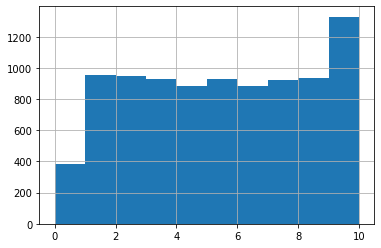

In [8]:
data_trg['Tenure'].hist(bins=10);

In [9]:
data_trg['Tenure'] = data_trg['Tenure'].fillna(random.randint(1, 9))

In [10]:
#data_trg['Tenure'] = data_trg['Tenure'].fillna(0)

In [11]:
data_trg['Tenure'].isna().sum()

0

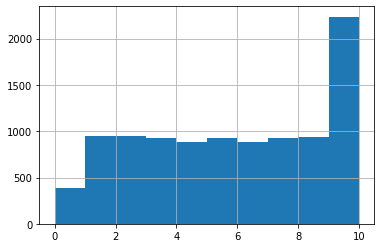

In [12]:
data_trg['Tenure'].hist(bins=10);

Применим технику OHE для категориальных признаков:

In [13]:
data_ohe = pd.get_dummies(data_trg, drop_first=True)

Далее нужно провести масштабирование признаков:

In [14]:
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler.fit(data_ohe[numeric])
data_ohe[numeric] = scaler.transform(data_ohe[numeric])

Все признаки количественные. Теперь нужно отобрать фичи и целевой признак. Затем разбить выборку на обучающую, валидационную и тестовую:

In [15]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = \
    train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

In [16]:
print(features_train.shape)
print(target_train.shape)
print()
print(features_valid.shape)
print(target_valid.shape)
print()
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)

(2000, 11)
(2000,)

(2000, 11)
(2000,)


#### Вывод
1. Удалили RowNumber, CustomerId, Surname из датасета
2. Пропуски в столбце Tenure заполнили случайным значением
3. Применили OHE для категориальных признаков, чтобы привести их количественным
4. Масштабировали признаки
4. Разделили данные на обучающую, валидационную и тестовую выборки.

### Шаг 2. Исследование данных

Посмотрим на распределение классов:

0    0.7963
1    0.2037
Name: Exited, dtype: float64


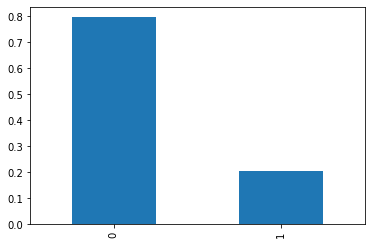

In [17]:
class_frequency = data_ohe['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Классы несбалансированные. Обучим модели без учёта дисбаланса классов. Рассчитаем метрики классификации: accuracy, precision, recall, F1, AUC-ROC, Error Matrix.

In [18]:
#RandomForestClassifier
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_train, target_train)
predicted_valid = model_forest.predict(features_valid)
print('Accuracy:', model_forest.score(features_valid, target_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))
probabilities_valid_forest = model_forest.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_forest))
confusion_matrix(target_valid, predicted_valid)

Accuracy: 0.8615
Precision 0.7877551020408163
Recall: 0.46172248803827753
F1: 0.5822021116138764
AUC-ROC: 0.8393174710710807


array([[1530,   52],
       [ 225,  193]])

In [19]:
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 51, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n)
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = model_forest.predict(features_valid)
        print("max_depth =", depth,":")
        print("estimators =", n, ":")
        print('Accuracy:', accuracy_score(target_valid, predicted_valid_forest))
        print('Recall:', recall_score(target_valid, predicted_valid_forest))
        print('Precision:', precision_score(target_valid, predicted_valid_forest))
        result_forest = f1_score(target_valid, predicted_valid_forest)
        print('F1:', result_forest)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
        print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_forest))
        print()
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_forest)
print('Estimators:', best_n_est)
print("Accuracy:", best_acc_forest)
print("Recall:", best_rec_forest)
print("Precision:", best_prec_forest)
print("F1:", best_f1_forest)
print("AUC-ROC:", best_roc_auc_forest)

max_depth = 1 :
estimators = 1 :
Accuracy: 0.8155
Recall: 0.145933014354067
Precision: 0.8356164383561644
F1: 0.2484725050916497
AUC-ROC: 0.5691738396675518

max_depth = 1 :
estimators = 6 :
Accuracy: 0.791
Recall: 0.0
Precision: 0.0
F1: 0.0
AUC-ROC: 0.7756776293106056

max_depth = 1 :
estimators = 11 :
Accuracy: 0.791
Recall: 0.0
Precision: 0.0
F1: 0.0
AUC-ROC: 0.741959484390784

max_depth = 1 :
estimators = 16 :
Accuracy: 0.791
Recall: 0.0
Precision: 0.0
F1: 0.0
AUC-ROC: 0.784472746629244

max_depth = 1 :
estimators = 21 :
Accuracy: 0.791
Recall: 0.0
Precision: 0.0
F1: 0.0
AUC-ROC: 0.7850050508411011

max_depth = 1 :
estimators = 26 :
Accuracy: 0.791
Recall: 0.0
Precision: 0.0
F1: 0.0
AUC-ROC: 0.789971963295205

max_depth = 1 :
estimators = 31 :
Accuracy: 0.791
Recall: 0.0
Precision: 0.0
F1: 0.0
AUC-ROC: 0.7943113011813524

max_depth = 1 :
estimators = 36 :
Accuracy: 0.791
Recall: 0.0
Precision: 0.0
F1: 0.0
AUC-ROC: 0.7969002353026574

max_depth = 1 :
estimators = 41 :
Accuracy: 0.79

max_depth = 6 :
estimators = 31 :
Accuracy: 0.856
Recall: 0.37559808612440193
Precision: 0.8532608695652174
F1: 0.5215946843853821
AUC-ROC: 0.847702018521767

max_depth = 6 :
estimators = 36 :
Accuracy: 0.8575
Recall: 0.37559808612440193
Precision: 0.8674033149171271
F1: 0.5242070116861437
AUC-ROC: 0.8486774055008802

max_depth = 6 :
estimators = 41 :
Accuracy: 0.8575
Recall: 0.37799043062200954
Precision: 0.8633879781420765
F1: 0.5257903494176372
AUC-ROC: 0.8495431559590851

max_depth = 6 :
estimators = 46 :
Accuracy: 0.857
Recall: 0.37799043062200954
Precision: 0.8586956521739131
F1: 0.5249169435215946
AUC-ROC: 0.8493019556130874

max_depth = 7 :
estimators = 1 :
Accuracy: 0.8265
Recall: 0.3373205741626794
Precision: 0.6682464454976303
F1: 0.44833068362480133
AUC-ROC: 0.7630951372800465

max_depth = 7 :
estimators = 6 :
Accuracy: 0.854
Recall: 0.42822966507177035
Precision: 0.771551724137931
F1: 0.5507692307692309
AUC-ROC: 0.8357176126156098

max_depth = 7 :
estimators = 11 :
Accurac

max_depth = 11 :
estimators = 41 :
Accuracy: 0.8575
Recall: 0.4258373205741627
Precision: 0.7982062780269058
F1: 0.5553822152886115
AUC-ROC: 0.8463470623461309

max_depth = 11 :
estimators = 46 :
Accuracy: 0.861
Recall: 0.4354066985645933
Precision: 0.8125
F1: 0.5669781931464175
AUC-ROC: 0.8475296245440633

max_depth = 12 :
estimators = 1 :
Accuracy: 0.8065
Recall: 0.46172248803827753
Precision: 0.543661971830986
F1: 0.499353169469599
AUC-ROC: 0.6828230572408496

max_depth = 12 :
estimators = 6 :
Accuracy: 0.8425
Recall: 0.45454545454545453
Precision: 0.6859205776173285
F1: 0.5467625899280575
AUC-ROC: 0.8133381522994938

max_depth = 12 :
estimators = 11 :
Accuracy: 0.8595
Recall: 0.4784688995215311
Precision: 0.7604562737642585
F1: 0.5873715124816447
AUC-ROC: 0.8301321989607969

max_depth = 12 :
estimators = 16 :
Accuracy: 0.858
Recall: 0.45454545454545453
Precision: 0.7723577235772358
F1: 0.572289156626506
AUC-ROC: 0.8370249336131963

max_depth = 12 :
estimators = 21 :
Accuracy: 0.857

max_depth = 17 :
estimators = 16 :
Accuracy: 0.851
Recall: 0.45454545454545453
Precision: 0.7307692307692307
F1: 0.56047197640118
AUC-ROC: 0.822407738977371

max_depth = 17 :
estimators = 21 :
Accuracy: 0.853
Recall: 0.47368421052631576
Precision: 0.7279411764705882
F1: 0.5739130434782609
AUC-ROC: 0.8265610728349433

max_depth = 17 :
estimators = 26 :
Accuracy: 0.8575
Recall: 0.46411483253588515
Precision: 0.7607843137254902
F1: 0.5765230312035662
AUC-ROC: 0.8272703077081279

max_depth = 17 :
estimators = 31 :
Accuracy: 0.8555
Recall: 0.46411483253588515
Precision: 0.749034749034749
F1: 0.5731166912850812
AUC-ROC: 0.8292755218698395

max_depth = 17 :
estimators = 36 :
Accuracy: 0.8595
Recall: 0.46411483253588515
Precision: 0.7729083665338645
F1: 0.5799701046337816
AUC-ROC: 0.8292241061221033

max_depth = 17 :
estimators = 41 :
Accuracy: 0.86
Recall: 0.48086124401913877
Precision: 0.7613636363636364
F1: 0.5894428152492669
AUC-ROC: 0.8307083577810173

max_depth = 17 :
estimators = 46 :
A

Обучим решающее дерево со стандартными параметрами:

In [20]:
#DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
predicted_valid = model_tree.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))
probabilities_valid_tree = model_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_tree))
confusion_matrix(target_valid, predicted_valid)

Accuracy: 0.781
Precision: 0.47641509433962265
Recall: 0.48325358851674644
F1: 0.47980997624703087
AUC-ROC: 0.6714624453329623


array([[1360,  222],
       [ 216,  202]])

In [21]:
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20): 
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_tree.fit(features_train, target_train)
    predictions_train = model_tree.predict(features_train)
    predictions_valid = model_tree.predict(features_valid)
    print("max_depth =", depth, ":")
    print('Accuracy:', accuracy_score(target_valid, predictions_valid))
    print('Recall:', recall_score(target_valid, predictions_valid))
    print('Precision:', precision_score(target_valid, predictions_valid))
    result_tree = f1_score(target_valid, predictions_valid)
    print('F1:', result_tree)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_tree))
    print()
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predictions_valid)
        best_rec_tree = recall_score(target_valid, predictions_valid)
        best_prec_tree = precision_score(target_valid, predictions_valid)
        best_f1_tree = f1_score(target_valid, predictions_valid)
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_tree)
print("Accuracy:", best_acc_tree)
print("Recall:", best_rec_tree)
print("Precision:", best_prec_tree)
print("F1:", best_f1_tree)
print("AUC-ROC:", best_roc_auc_tree)

max_depth = 1 :
Accuracy: 0.791
Recall: 0.0
Precision: 0.0
F1: 0.0
AUC-ROC: 0.6925565119556736

max_depth = 2 :
Accuracy: 0.824
Recall: 0.45933014354066987
Precision: 0.6037735849056604
F1: 0.5217391304347825
AUC-ROC: 0.7501814673449512

max_depth = 3 :
Accuracy: 0.838
Recall: 0.284688995215311
Precision: 0.8263888888888888
F1: 0.4234875444839857
AUC-ROC: 0.7973440741838507

max_depth = 4 :
Accuracy: 0.852
Recall: 0.43779904306220097
Precision: 0.75
F1: 0.5528700906344411
AUC-ROC: 0.813428129858032

max_depth = 5 :
Accuracy: 0.853
Recall: 0.4138755980861244
Precision: 0.7792792792792793
F1: 0.5406249999999999
AUC-ROC: 0.8221680508592478

max_depth = 6 :
Accuracy: 0.858
Recall: 0.44976076555023925
Precision: 0.7768595041322314
F1: 0.5696969696969697
AUC-ROC: 0.8164631712023421

max_depth = 7 :
Accuracy: 0.8505
Recall: 0.40669856459330145
Precision: 0.7692307692307693
F1: 0.5320813771517998
AUC-ROC: 0.8138530658907929

max_depth = 8 :
Accuracy: 0.8475
Recall: 0.41866028708133973
Precisio

In [22]:
#LogisticRegression
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_train, target_train)
predicted_valid = model_log.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_log))
confusion_matrix(target_valid, predicted_valid)

Accuracy: 0.8035
Precision: 0.5714285714285714
Recall: 0.23923444976076555
F1: 0.33726812816188867
AUC-ROC: 0.7584820861485976


array([[1507,   75],
       [ 318,  100]])

Необходимо построить ROC-кривую:

AUC-ROC DecisionTreeClassifier 0.6749594722929608
AUC-ROC RandomForestClassifier 0.8345426115570503
AUC-ROC LogisticRegression 0.7584820861485976


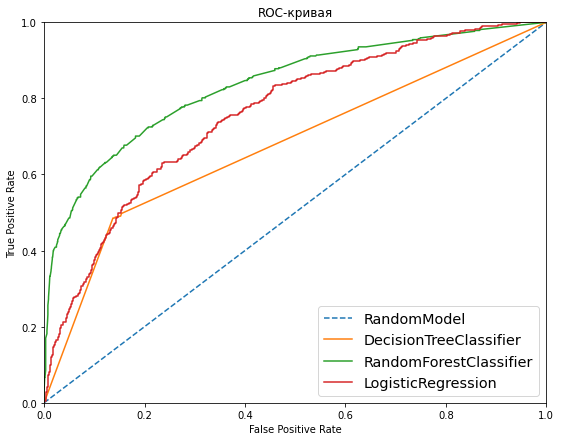

In [26]:
plt.figure(figsize=[9,7])
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_tree)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_tree)
print('AUC-ROC DecisionTreeClassifier', auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_forest)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_forest)
print('AUC-ROC RandomForestClassifier', auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_log)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_log)
print('AUC-ROC LogisticRegression', auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

#### Вывод

Самый хороший показатель у RandomForestClassifier с парметрами:

- Depth: 17
- Estimators: 41
- Accuracy: 0.86
- Recall: 0.48086124401913877
- Precision: 0.7613636363636364
- F1: 0.5894428152492669
- AUC-ROC: 0.8307083577810173

### Шаг 3. Дисбаланс классов

In [27]:
model_forest_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest_balanced.fit(features_train, target_train)
predictions_valid = model_forest_balanced.predict(features_valid)
probabilities_valid = model_forest_balanced.predict_proba(features_valid)
print('Accuracy:',accuracy_score(target_valid, predictions_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('AUC-ROC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

Accuracy: 0.8515
F1: 0.543778801843318
AUC-ROC: 0.8359504957082972


In [28]:
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 51, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n, class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predicted_valid_forest)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_forest)
print('Estimators:', best_n_est)
print("Accuracy:", best_acc_forest)
print("Recall:", best_rec_forest)
print("Precision:", best_prec_forest)
print("F1:", best_f1_forest)
print("AUC-ROC:", best_roc_auc_forest)


Лучшие параметры модели:
Depth: 7
Estimators: 31
Accuracy: 0.828
Recall: 0.7057416267942583
Precision: 0.5717054263565892
F1: 0.6316916488222698
AUC-ROC: 0.8515960052988464


После балансирования классов F1 случайного леса увеличился с 0.5894428152492669 до 0.6316916488222698

In [29]:
model_tree_balanced = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree_balanced.fit(features_train, target_train)
predictions_valid = model_tree_balanced.predict(features_valid)
probabilities_valid = model_tree_balanced.predict_proba(features_valid)
print('Accuracy:', accuracy_score(target_valid, predictions_valid))
print('F1:', f1_score(target_valid, predictions_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_valid[:,1]))

Accuracy: 0.795
F1: 0.5012165450121654
AUC-ROC: 0.683832469347141


In [30]:
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20): 
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model_tree.fit(features_train, target_train)
    predictions_train = model_tree.predict(features_train)
    predictions_valid = model_tree.predict(features_valid)
    result_tree = f1_score(target_valid, predictions_valid)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predictions_valid)
        best_rec_tree = recall_score(target_valid, predictions_valid)
        best_prec_tree = precision_score(target_valid, predictions_valid)
        best_f1_tree = f1_score(target_valid, predictions_valid)
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_tree)
print("Accuracy:", best_acc_tree)
print("Recall:", best_rec_tree)
print("Precision:", best_prec_tree)
print("F1:", best_f1_tree)
print("AUC-ROC:", best_roc_auc_tree)


Лучшие параметры модели:
Depth: 5
Accuracy: 0.8105
Recall: 0.6698564593301436
Precision: 0.5374280230326296
F1: 0.5963791267305644
AUC-ROC: 0.8310244134068074


В модели решающего дерева F1 также увеличился с 0.5696969696969697 до 0.5963791267305644, рост меньше, чем у случайного леса.

In [31]:
model_log = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_log.fit(features_train, target_train)
predicted_valid = model_log.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_log))
confusion_matrix(target_valid, predicted_valid)

Accuracy: 0.7
Precision: 0.37898936170212766
Recall: 0.6818181818181818
F1: 0.48717948717948717
AUC-ROC: 0.7634724381347575


array([[1115,  467],
       [ 133,  285]])

В логистической регрессии метрика F1 выросла с 0.33726812816188867 до 0.48717948717948717

Метрики получилось увеличить, но объекты положительного класса по-прежнему редки. Применим технику **upsampling**, увеличим количество объектов положительного класса. Балансируем только train выборку:

In [32]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [34]:
print(features_upsampled.shape)
print(target_upsampled.shape)

(9588, 11)
(9588,)


После увеличения положительного класса обучим модели решающего дерева и случайного леса.

In [35]:
model_forest_balanced_up = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest_balanced_up.fit(features_upsampled, target_upsampled)
predictions_valid = model_forest_balanced_up.predict(features_valid)
probabilities_valid = model_forest_balanced_up.predict_proba(features_valid)
print('Accuracy:',accuracy_score(target_valid, predictions_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('AUC-ROC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

Accuracy: 0.849
F1: 0.5994694960212201
AUC-ROC: 0.8378271705006682


In [36]:
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 51, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n, class_weight='balanced')
        model_forest.fit(features_upsampled, target_upsampled)
        predicted_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predicted_valid_forest)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_forest)
print('Estimators:', best_n_est)
print("Accuracy:", best_acc_forest)
print("Recall:", best_rec_forest)
print("Precision:", best_prec_forest)
print("F1:", best_f1_forest)
print("AUC-ROC:", best_roc_auc_forest)


Лучшие параметры модели:
Depth: 12
Estimators: 16
Accuracy: 0.8405
Recall: 0.6578947368421053
Precision: 0.6097560975609756
F1: 0.6329113924050632
AUC-ROC: 0.8456869748788706


Значение F1 незначительно увеличилось с 0.6316916488222698 до 0.6329113924050632

In [37]:
model_tree_balanced = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree_balanced.fit(features_upsampled, target_upsampled)
predictions_valid = model_tree_balanced.predict(features_valid)
probabilities_valid = model_tree_balanced.predict_proba(features_valid)
print('Accuracy:', accuracy_score(target_valid, predictions_valid))
print('F1:', f1_score(target_valid, predictions_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_valid[:,1]))

Accuracy: 0.7975
F1: 0.49689440993788814
AUC-ROC: 0.6801320477380096


In [38]:
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20): 
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model_tree.fit(features_upsampled, target_upsampled)
    predictions_train = model_tree.predict(features_train)
    predictions_valid = model_tree.predict(features_valid)
    result_tree = f1_score(target_valid, predictions_valid)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predictions_valid)
        best_rec_tree = recall_score(target_valid, predictions_valid)
        best_prec_tree = precision_score(target_valid, predictions_valid)
        best_f1_tree = f1_score(target_valid, predictions_valid)
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_tree)
print("Accuracy:", best_acc_tree)
print("Recall:", best_rec_tree)
print("Precision:", best_prec_tree)
print("F1:", best_f1_tree)
print("AUC-ROC:", best_roc_auc_tree)


Лучшие параметры модели:
Depth: 5
Accuracy: 0.8105
Recall: 0.6698564593301436
Precision: 0.5374280230326296
F1: 0.5963791267305644
AUC-ROC: 0.8310244134068074


Значение F1 до и после увеличения положительного класса осталось прежним.

In [39]:
model_log = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_log.fit(features_upsampled, target_upsampled)
predicted_valid = model_log.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_log))
confusion_matrix(target_valid, predicted_valid)

Accuracy: 0.701
Precision: 0.3803191489361702
Recall: 0.6842105263157895
F1: 0.4888888888888888
AUC-ROC: 0.7634270712985198


array([[1116,  466],
       [ 132,  286]])

F1 логистической регрессии уменьшилось.

Далее можно применить обратную технику **downsampling**, уменьшим количество объектов отрицательного класса:

In [46]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [47]:
print(features_downsampled.shape)
print(target_downsampled.shape)
print(target_downsampled.value_counts(normalize=True))

(2397, 11)
(2397,)
0    0.501043
1    0.498957
Name: Exited, dtype: float64


In [49]:
model_forest_balanced3 = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest_balanced3.fit(features_downsampled, target_downsampled)
predictions_valid = model_forest_balanced3.predict(features_valid)
probabilities_valid = model_forest_balanced3.predict_proba(features_valid)
print('Accuracy:',accuracy_score(target_valid, predictions_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('ROC-AUC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

Accuracy: 0.7785
F1: 0.5863678804855276
ROC-AUC: 0.8428764993739377


In [50]:
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 51, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n, class_weight='balanced')
        model_forest.fit(features_downsampled, target_downsampled)
        predicted_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predicted_valid_forest)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_forest)
print('Estimators:', best_n_est)
print("Accuracy:", best_acc_forest)
print("Recall:", best_rec_forest)
print("Precision:", best_prec_forest)
print("F1:", best_f1_forest)
print("AUC-ROC:", best_roc_auc_forest)


Лучшие параметры модели:
Depth: 10
Estimators: 31
Accuracy: 0.795
Recall: 0.7440191387559809
Precision: 0.506514657980456
F1: 0.6027131782945737
AUC-ROC: 0.8494032748806852


F1 уменьшилась после уменьшения отрицательного класса.

In [52]:
model_tree_balanced = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree_balanced.fit(features_downsampled, target_downsampled)
predictions_valid = model_tree_balanced.predict(features_valid)
probabilities_valid = model_tree_balanced.predict_proba(features_valid)
print('Accuracy:', accuracy_score(target_valid, predictions_valid))
print('F1:', f1_score(target_valid, predictions_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_valid[:,1]))

Accuracy: 0.697
F1: 0.4916107382550336
AUC-ROC: 0.6984557128944646


In [53]:
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20): 
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model_tree.fit(features_downsampled, target_downsampled)
    predictions_train = model_tree.predict(features_train)
    predictions_valid = model_tree.predict(features_valid)
    result_tree = f1_score(target_valid, predictions_valid)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predictions_valid)
        best_rec_tree = recall_score(target_valid, predictions_valid)
        best_prec_tree = precision_score(target_valid, predictions_valid)
        best_f1_tree = f1_score(target_valid, predictions_valid)
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_tree)
print("Accuracy:", best_acc_tree)
print("Recall:", best_rec_tree)
print("Precision:", best_prec_tree)
print("F1:", best_f1_tree)
print("AUC-ROC:", best_roc_auc_tree)


Лучшие параметры модели:
Depth: 5
Accuracy: 0.7995
Recall: 0.6985645933014354
Precision: 0.5149911816578483
F1: 0.5928934010152282
AUC-ROC: 0.8217272364338039


F1 уменьшилось.

In [55]:
model_log = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_log.fit(features_downsampled, target_downsampled)
predicted_valid = model_log.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_log))
confusion_matrix(target_valid, predicted_valid)

Accuracy: 0.6995
Precision: 0.3765182186234818
Recall: 0.6674641148325359
F1: 0.48144952545297665
AUC-ROC: 0.7620675784392598


array([[1120,  462],
       [ 139,  279]])

#### Вывод
После увеличения положительного класса F1 случайного леса незначительно увеличился.

- Depth: 12
- Estimators: 16
- **F1: 0.6329113924050632**


### Шаг 4. Тестирование

Протестируем модель на выборке train + valid

In [93]:
features = pd.concat([features_upsampled, features_valid], axis=0).reset_index(drop=True)
target = pd.concat([target_upsampled, target_valid], axis=0).reset_index(drop=True)

In [94]:
model = RandomForestClassifier(n_estimators = 16, max_depth=12, random_state=12345, class_weight='balanced')
model.fit(features, target)
predicted_valid = model.predict(features_test)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy_valid = accuracy_score(predicted_valid, target_test)
print('Accuracy:', accuracy_valid)
print('F1:', f1_score(target_test, predicted_valid))

Accuracy: 0.827
F1: 0.6022988505747127


ROC-кривая:

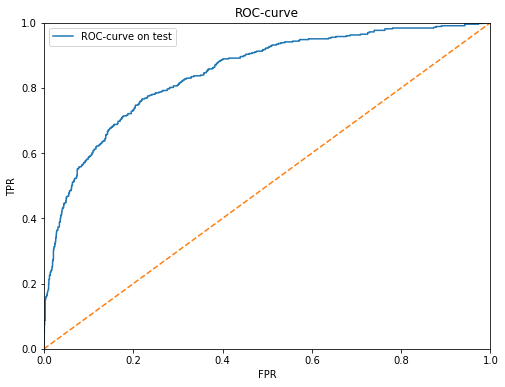

In [95]:
plt.figure(figsize=[8,6])
fpr_test, tpr_test, thresholds = roc_curve(target_test, probabilities_one_valid)
plt.plot(fpr_test, tpr_test, label='ROC-curve on test')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-curve')
plt.show()

Важность признаков:

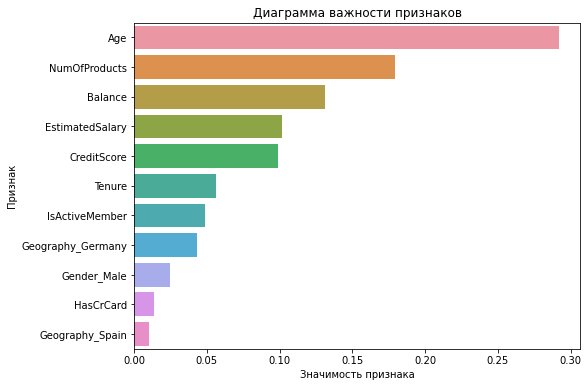

In [96]:
plt.figure(figsize=[8,6])
feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)
ax = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = ax.set(xlabel='Значимость признака', ylabel='Признак')
_ = ax.set_title('Диаграмма важности признаков')

#### Вывод
Метрика F1 поднялась до 0.6022988505747127